In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow import keras
from sklearn.datasets import load_sample_image

In [15]:
watch -n 0.1 nvidia-smi

SyntaxError: invalid syntax (<ipython-input-15-583800809c66>, line 1)

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


In [4]:
china = load_sample_image('china.jpg') / 255
flower = load_sample_image('flower.jpg') / 255

In [5]:
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

In [6]:
flower.shape

(427, 640, 3)

In [7]:
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1         # 수직선
filters[3, :, :, 1] = 1         # 수평선

In [8]:
outputs = tf.nn.conv2d(images, filters, strides=1, padding='SAME')

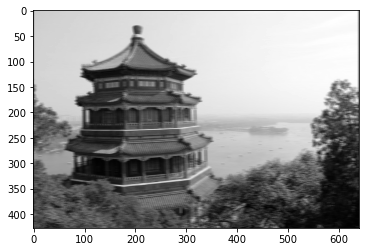

In [9]:
plt.imshow(outputs[0, :, :, 1], cmap='gray')
plt.show()

In [17]:
# 최대 플링 층
max_pool = keras.layers.MaxPool2D(2)

In [18]:
# 평균 플링 층
avg_pool = keras.layers.AvgPool2D(2)

In [23]:
# output = tf.nn.max_pool(images, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding='VALID')

In [26]:
#케라스에서 모델 층을 사용하고 싶으면 아래와 같이
depth_pool = keras.layers.Lambda(lambda x: tf.nn.max_pool(x, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding='VALID'))

In [27]:
# 전역 평균 폴링 층
global_avg_pool = keras.layers.GlobalAvgPool2D()

In [28]:
# 전역 평균 폴링층과 같다.
global_avg_pool_lambda = keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=[1, 2]))

In [83]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [84]:
x_mean = x_train.mean(axis=0, keepdims=True)
x_std = x_train.std(axis=0, keepdims=True) + 1e-7

In [85]:
x_train = (x_train - x_mean) / x_std
x_test = (x_test / x_mean) / x_std

In [86]:
x_train.shape

(60000, 28, 28)

In [88]:
x_train = x_train[:,:,:, np.newaxis]
x_test = x_test[:,:,:, np.newaxis]
x_train.shape

(60000, 28, 28, 1)

In [90]:
#  CNN 구조
model = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation='relu', padding='same', input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(.5),
    keras.layers.Dense(10, activation='softmax')
])

In [91]:
model.compile(loss = keras.losses.sparse_categorical_crossentropy,
             optimizer = keras.optimizers.Nadam(),
             metrics = ['accuracy'])

In [92]:
history = model.fit(x_train, y_train, epochs=10, validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
   32/48000 [..............................] - ETA: 2:49:58

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential_17/conv2d_91/Conv2D (defined at <ipython-input-92-d22c81ce273f>:1) ]] [Op:__inference_distributed_function_12255]

Function call stack:
distributed_function


In [ ]:
class RasidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides = 1, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers=[
            keras.layers.Conv2D(filters, 3, strides=strides, 
                                padding='SAME', use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters, 3, strides=1, 
                                padding='SAME', use_bias=False),
            keras.layers.BatchNormalization()]
        self.skip_layers=[]
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, 1, strides=strides, 
                                    padding='SAME', use_bias=False),
                keras.layers.BatchNormalization()]
            
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [ ]:
strides = 2
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[224, 224, 3], padding='same', use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPool2D(3, strides=2, padding='SAME'))
prev_filters = 64

for filters in [64] * 3 + [128] * 4 + [256] * 6+ [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(RasidualUnit(filters, strides=strides))
    prev_filters = filters

model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation='softmax'))

In [ ]:
model.summary()

In [10]:
model = keras.applications.resnet50.ResNet50(weights='imagenet')

In [11]:
image_resized = tf.image.resize(images, [244, 244])

In [12]:
def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

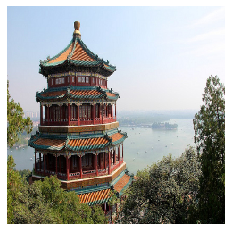

In [14]:
plot_color_image(image_resized[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


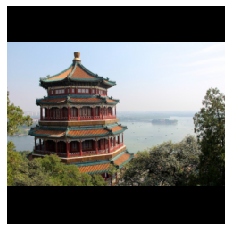

In [16]:
images_resized = tf.image.resize_with_pad(images, 244, 244, antialias=True)
plot_color_image(images_resized[0])

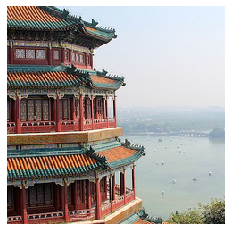

In [17]:
images_resized = tf.image.resize_with_crop_or_pad(images, 244, 244)
plot_color_image(images_resized[0])

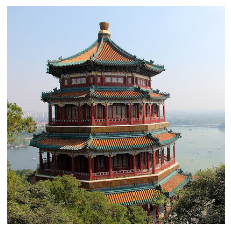

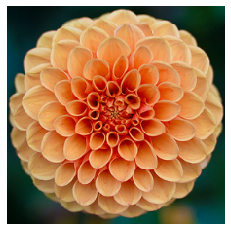

In [20]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

In [22]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)

In [23]:
top_k = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print('image #{}'.format(image_index))
    for class_id, name, y_proba in top_k[image_index]:
        print(' {}- {:12s} {:.2f}'.format(class_id, name, y_proba*100))
    print()

40960/35363 [==================================] - 0s 0us/step
image #0
 n03877845- palace       43.39
 n02825657- bell_cote    43.07
 n03781244- monastery    11.70

image #1
 n04522168- vase         53.96
 n07930864- cup          9.52
 n11939491- daisy        4.97



In [27]:
import tensorflow_datasets as tfds

In [28]:
dataset, info = tfds.load('tf_flowers', as_supervised=True, with_info=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to C:\Users\Administrator\tensorflow_datasets\tf_flowers\3.0.0. Subsequent calls will reuse this data.


In [29]:
dataset_size = info.splits['train'].num_examples

In [48]:
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.0,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)

In [39]:
class_names = info.features['label'].names

In [40]:
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [43]:
n_classes = info.features['label'].num_classes

In [44]:
n_classes

5

In [61]:
test_set, valid_set, train_set = tfds.load('tf_flowers', 
                                           split=['train[:10%]', 'train[10%:25%]', 'train[25%:]'], as_supervised=True)

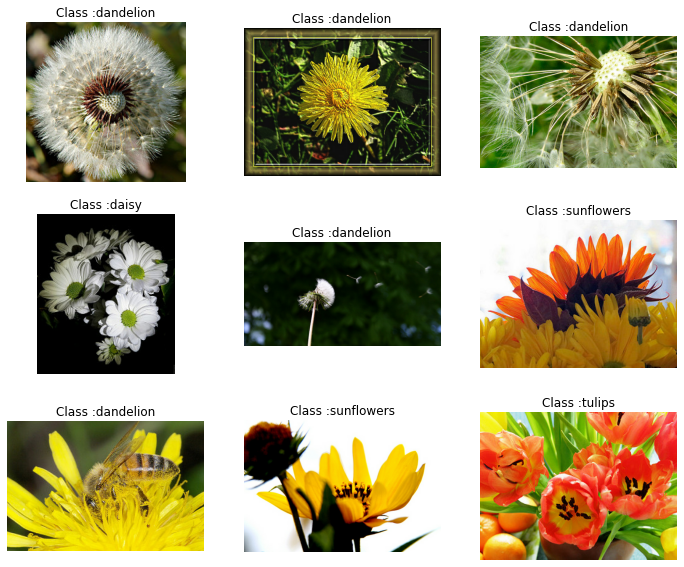

In [62]:
plt.figure(figsize=(12, 10))
index = 0

for image, label in train_set.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title('Class :{}'.format(class_names[label]))
    plt.axis('off')

plt.show()

In [63]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    
    return final_image, label

In [64]:
batch_size = 32
train_set = train_set.shuffle(1000)
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)

In [65]:
valid_set = valid_set.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set.map(preprocess).batch(batch_size).prefetch(1)

In [66]:
base_model = keras.applications.xception.Xception(weights='imagenet', include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation='softmax')(avg)
model = keras.Model(inputs=base_model.input, outputs = output)

83689472/83683744 [==============================] - 23s 0us/step


In [67]:
for layer in base_model.layers:
    layer.trainable = False

In [68]:
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay = 0.01)

In [69]:
model.compile(loss = keras.losses.sparse_categorical_crossentropy,
             optimizer = optimizer,
             metrics=['accuracy'])

In [70]:
history = model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
86/86 [==============================] - 17s 198ms/step - loss: 0.6628 - accuracy: 0.7787 - val_loss: 1.3090 - val_accuracy: 0.7332
Epoch 2/5
86/86 [==============================] - 13s 149ms/step - loss: 0.3528 - accuracy: 0.8812 - val_loss: 1.1416 - val_accuracy: 0.7677
Epoch 3/5
86/86 [==============================] - 13s 149ms/step - loss: 0.2398 - accuracy: 0.9230 - val_loss: 1.1604 - val_accuracy: 0.7713
Epoch 4/5
86/86 [==============================] - 13s 149ms/step - loss: 0.2005 - accuracy: 0.9302 - val_loss: 1.0506 - val_accuracy: 0.7768
Epoch 5/5
86/86 [==============================] - 13s 149ms/step - loss: 0.2009 - accuracy: 0.9284 - val_loss: 1.1111 - val_accuracy: 0.7641


In [71]:
for layer in base_model.layers:
    layer.trainable = True

In [72]:
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay = 0.01)

In [73]:
model.compile(loss = keras.losses.sparse_categorical_crossentropy,
             optimizer = optimizer,
             metrics=['accuracy'])

In [74]:
history = model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
86/86 [==============================] - 52s 607ms/step - loss: 0.2077 - accuracy: 0.9277 - val_loss: 0.6204 - val_accuracy: 0.8639
Epoch 2/5
86/86 [==============================] - 47s 547ms/step - loss: 0.0389 - accuracy: 0.9884 - val_loss: 0.4436 - val_accuracy: 0.8766
Epoch 3/5
86/86 [==============================] - 50s 578ms/step - loss: 0.0146 - accuracy: 0.9975 - val_loss: 0.3754 - val_accuracy: 0.8857
Epoch 4/5
86/86 [==============================] - 50s 581ms/step - loss: 0.0061 - accuracy: 0.9989 - val_loss: 0.3193 - val_accuracy: 0.9056
Epoch 5/5
86/86 [==============================] - 50s 579ms/step - loss: 0.0092 - accuracy: 0.9978 - val_loss: 0.3038 - val_accuracy: 0.9056


In [75]:
model.evaluate(test_set)

     12/Unknown - 2s 140ms/step - loss: 0.3143 - accuracy: 0.9074

[0.31426549912430346, 0.907357]

In [76]:
base_model = keras.applications.xception.Xception(weights = 'imagenet', include_top = False)

In [79]:
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation='softmax')(avg)
loc_output = keras.layers.Dense(4)(avg)

In [83]:
model = keras.Model(inputs=base_model.input,
                   outputs = [class_output, loc_output])

In [84]:
model.compile(loss = keras.losses.sparse_categorical_crossentropy,
             loss_weights=[0.8, 0.2],
             optimizer = optimizer, metrics = [keras.metrics.categorical_accuracy])